In [1]:
from scripts.utils.load_data import load_data_and_clean_column_names
from scripts.utils.preprocess import bin_weeks_worked, num_to_cat_features, binarize_target
from scripts.utils.model_pipeline import run_model, get_scoring_metrics
import numpy as np
import pandas as pd


In [2]:
#read in the data 
X_train = load_data_and_clean_column_names('data/training_data.csv', metadata='data/census_metadata.txt')
X_test = load_data_and_clean_column_names('data/test_data.csv', metadata='data/census_metadata.txt')
#Make the target variable binary and split off the target variable
X_train['income'] = X_train['income'].apply(binarize_target)
X_test['income'] = X_test['income'].apply(binarize_target)
y_train = X_train.pop('income')
y_test = X_test.pop('income')

In [3]:
# Drop columns with almost 50% nulls
X_train.drop(['migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'migration prev res in sunbelt'], axis = 1, inplace = True)
X_test.drop(['migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'migration prev res in sunbelt'], axis = 1, inplace = True)

In [4]:
# Let's fill the missing values in the categorical features with nan's, and we'll use our pipeline to impute the modal values. 
X_train.replace(' ?', np.nan, inplace=True)
X_test.replace(' ?', np.nan, inplace=True)

In [5]:
#Drop columns with large crossover to others 
X_train.drop(['industry code', 'occupation code'], axis = 1, inplace = True)
X_test.drop(['industry code', 'occupation code'], axis = 1, inplace = True)

In [6]:
#Drop instance weight and year
X_train.drop(['instance weight', 'year'], axis = 1, inplace = True)
X_test.drop(['instance weight', 'year'], axis = 1, inplace = True)

In [7]:
X_train.select_dtypes(exclude='object').describe()

,age,wage per hour,capital gains,capital losses,divdends from stocks,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year
count,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000,199522.000000
mean,34.494006,55.427186,434.721169,37.313975,197.530523,1.956190,0.175439,1.514830,23.175013
std,22.310785,274.897115,4697.542951,271.897097,1984.168581,2.365127,0.553696,0.851475,24.411494
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000
75%,50.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000


In [8]:
# Change numerical features that should be categorical to categorical and bin weeks worked

X_train['weeks worked in year'] = X_train['weeks worked in year'].apply(bin_weeks_worked)
X_test['weeks worked in year'] = X_test['weeks worked in year'].apply(bin_weeks_worked)

In [9]:
X_train = X_train.astype({'num persons worked for employer':str, 'own business or self employed':str, 'veterans benefits':str})
X_test = X_test.astype({'num persons worked for employer':str, 'own business or self employed':str, 'veterans benefits':str})

In [10]:
#Manually reorder columns now as it makes things easier later on when attempting to separate numerical and categorical features. Pipeline does this for us but this is useful
X_train = X_train[list(X_train.select_dtypes(exclude='object').columns.append( X_train.select_dtypes(include='object').columns))]
X_test = X_test[list(X_test.select_dtypes(exclude='object').columns.append( X_test.select_dtypes(include='object').columns))]


In [11]:
# Clean the column names
X_train.columns = list(map(lambda s: s.replace(' ' , '_').replace(',' , '').replace('<' , ''), X_train.columns))
X_test.columns = list(map(lambda s: s.replace(' ' , '_').replace(',' , '').replace('<' , ''), X_test.columns))

In [70]:
#Let's use F1 score and a dummy classifier to give us a baseline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
for strategy in ["uniform", "stratified", "most_frequent","constant", "prior"]:
    dummy_clf = DummyClassifier(strategy = strategy, constant=1)
    cv = StratifiedKFold(5)
    print(strategy)
    print(np.mean(cross_val_score(dummy_clf, X_train, y_train, scoring = 'f1', cv = cv)))
    

uniform
0.11069001802769982
stratified
0.05916984137362312
most_frequent
0.0
constant
0.11686423993873649
prior
0.0


In [68]:
#We have low baselines to compare with for F1 score

In the previous modelling notebook I compared a few models out of the box, XGBoost Classifier performed notably well with the default parameters so I'll attempt to tune it to improve the performance further. 

In [12]:
from xgboost import XGBClassifier

xgboostclf= XGBClassifier()

In [14]:
piped_model_gs = run_model(X = X_train, y= y_train, modelname = "xgboostclf", ml_model = xgboostclf, params = {}, search_selection = 'grid', verbosity = 1, njobs = -1)

Starting process '<function run_model at 0x1342f2290>'...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Finished process '<function run_model at 0x1342f2290>' in 144.43s


In [15]:
get_scoring_metrics(piped_model_gs, X_train, y_train)

{'y_validation_preds': array([0, 0, 0, ..., 1, 0, 0]),
 'accuracy': 0.9480959493188721,
 'recall': 0.6762235503149734,
 'precision': 0.5688179347826087,
 'f1': 0.6178879787469559}

In [16]:
from sklearn.metrics import precision_recall_curve

In [17]:
precisions, recalls, thresholds = precision_recall_curve(y_train, piped_model_gs.predict_proba(X_train)[:,1])
distance_to_optim = abs(recalls - 0.8)
optimal_idx = np.argmin(distance_to_optim)
thresh = thresholds[optimal_idx]
print(thresh)

0.31725776


In [18]:
# Adjusting the prediction threshold could be worth doing - default is 0.5 so this would get us closer to 0.8 recall

In [17]:
params = {"xgboostclf__min_child_weight" : [8, 10, 15, 20],
          "xgboostclf__max_depth": range(3,8, 1),
          "xgboostclf__n_estimators": range(20, 100, 20),
          "xgboostclf__learning_rate": np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=100),
          "xgboostclf__gamma": np.linspace(0, 1, 11)
          }

In [18]:
piped_model_gs_v2 = run_model(X = X_train, y= y_train, modelname = "xgboostclf", ml_model = xgboostclf, params = params, scoring_metric= 'roc_auc', search_selection = 'random',k_folds=3, verbosity = 3, njobs = -1)


Starting process '<function run_model at 0x12982dfc0>'...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END SMOTE__sampling_strategy=0.2, UNDER__sampling_strategy=0.5, xgboostclf__gamma=0.0, xgboostclf__learning_rate=0.3962414491769588, xgboostclf__max_depth=3, xgboostclf__min_child_weight=10, xgboostclf__n_estimators=40;, score=0.940 total time= 2.5min
[CV 2/3] END SMOTE__sampling_strategy=0.2, UNDER__sampling_strategy=0.5, xgboostclf__gamma=0.0, xgboostclf__learning_rate=0.3962414491769588, xgboostclf__max_depth=3, xgboostclf__min_child_weight=10, xgboostclf__n_estimators=40;, score=0.941 total time= 2.5min
[CV 1/3] END SMOTE__sampling_strategy=0.2, UNDER__sampling_strategy=0.5, xgboostclf__gamma=0.6000000000000001, xgboostclf__learning_rate=0.05117655109495131, xgboostclf__max_depth=5, xgboostclf__min_child_weight=8, xgboostclf__n_estimators=40;, score=0.930 total time= 2.7min
[CV 2/3] END SMOTE__sampling_strategy=0.2, UNDER__sampling_strategy=0.5, xgboostclf

In [19]:
get_scoring_metrics(piped_model_gs_v2, X_train, y_train)

{'y_validation_preds': array([0, 0, 0, ..., 1, 0, 0]),
 'accuracy': 0.9461613255681077,
 'recall': 0.6614440316588597,
 'precision': 0.5556309362279511,
 'f1': 0.6039377627018656}

In [19]:
# A Random Search over the param space failed to improve on the XGBoost with default features

In [20]:
#At this point, if I had time I would carry out further hyperparameter tuning. I would do this before checking how my model performs on the test set.

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

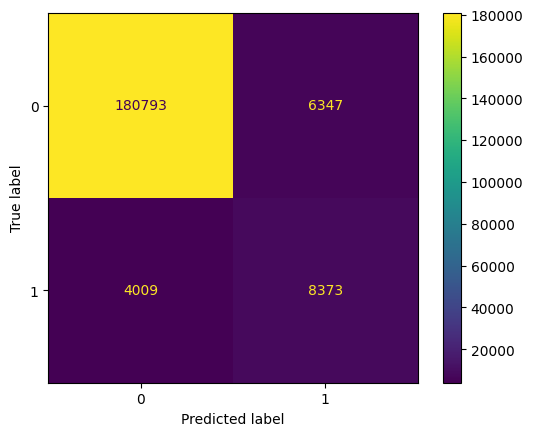

In [22]:
cm = confusion_matrix(y_train, get_scoring_metrics(piped_model_gs, X_train, y_train)["y_validation_preds"], labels=piped_model_gs.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=piped_model_gs.classes_).plot();

In [23]:
get_scoring_metrics(piped_model_gs, X_test, y_test)

{'y_validation_preds': array([0, 0, 0, ..., 0, 0, 0]),
 'accuracy': 0.9471035775503454,
 'recall': 0.6665050113158746,
 'precision': 0.561946299577484,
 'f1': 0.6097759372920211}

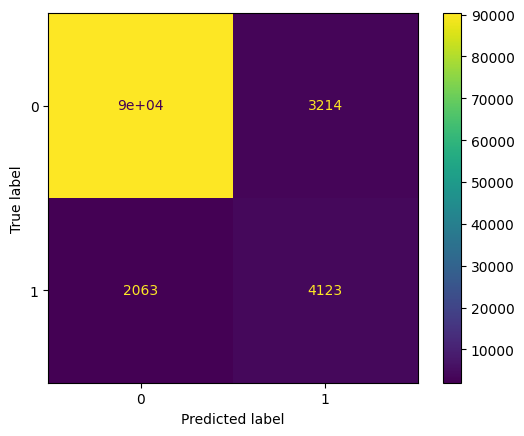

In [24]:
cm = confusion_matrix(y_test, get_scoring_metrics(piped_model_gs, X_test, y_test)["y_validation_preds"], labels=piped_model_gs.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=piped_model_gs.classes_).plot();

In [26]:
# The model performance doesn't change much when predicting the test set, which is good news because it means our model generalises well to unseen data! 

In [27]:
# Lets save our predictions for the test set 
y_test_preds = pd.Series(piped_model_gs.predict(X_test))
y_preds_with_truth = pd.DataFrame(list(zip(y_test_preds, y_test)), columns = ['preds', 'true'])

In [71]:
piped_model_gs

Pipeline(steps=[('FeatureEngineering',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'wage_per_hour',
                                                   'capital_gains',
                                                   'capital_losses',
                                                   'divdends_from_stocks']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncod...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

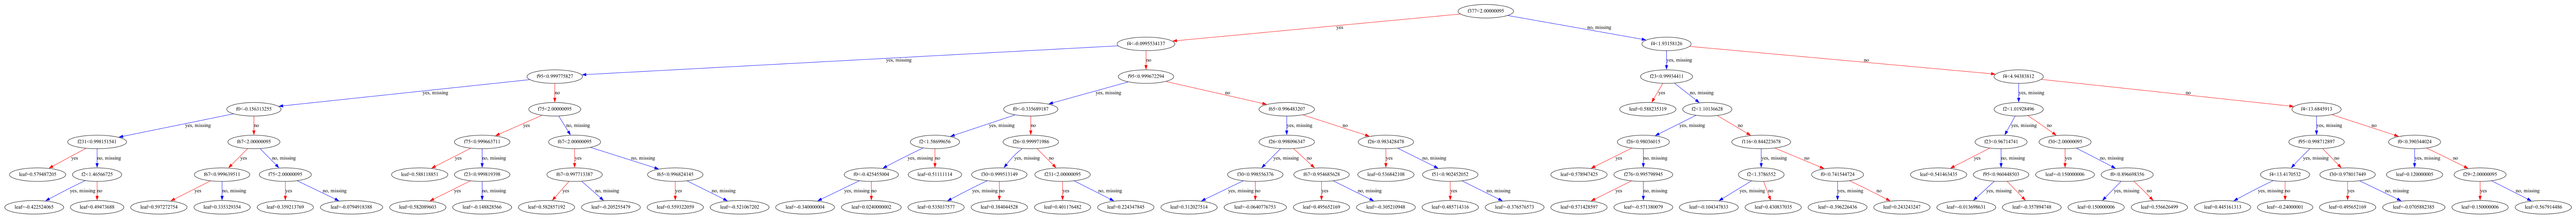

In [86]:
from xgboost import plot_tree
fig, ax = plt.subplots(figsize=(100, 50))
#plt.figure(figsize= (120, 120))
plot_tree(piped_model_gs.named_steps["xgboostclf"],ax = ax, fontsize = 10)
plt.show()

In [28]:
piped_model_gs.named_steps["xgboostclf"]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

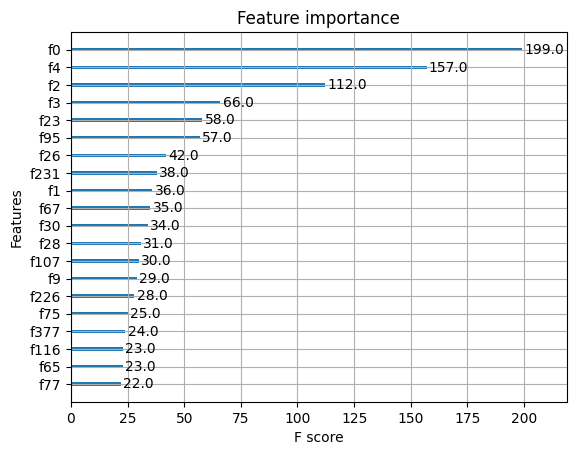

In [29]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(piped_model_gs.named_steps["xgboostclf"], max_num_features= 20, )
plt.show()

In [30]:
import seaborn as sns

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

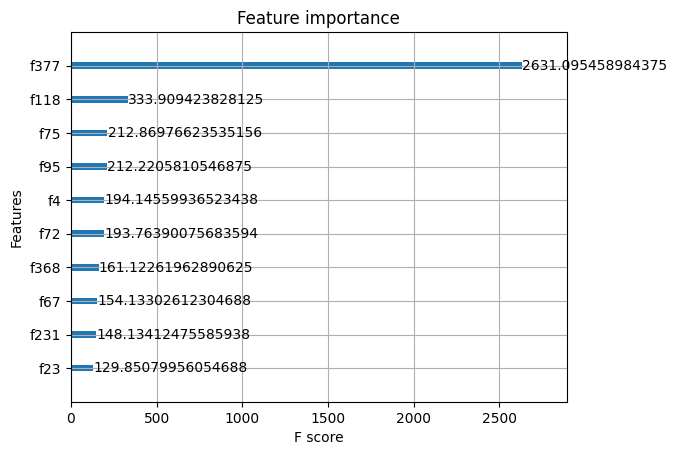

In [31]:
plot_importance(piped_model_gs.named_steps["xgboostclf"], max_num_features= 10, importance_type = 'gain')

In [32]:
#These plots weren't too useful so I wrote a function that includes our feature names. This was not as easy as I first thought as not all features are used in the model

In [33]:
from scripts.utils.model_eval import plot_feature_importances

/Users/alexdcruz/ds_projects/dataiku_task/scripts/utils/model_eval.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


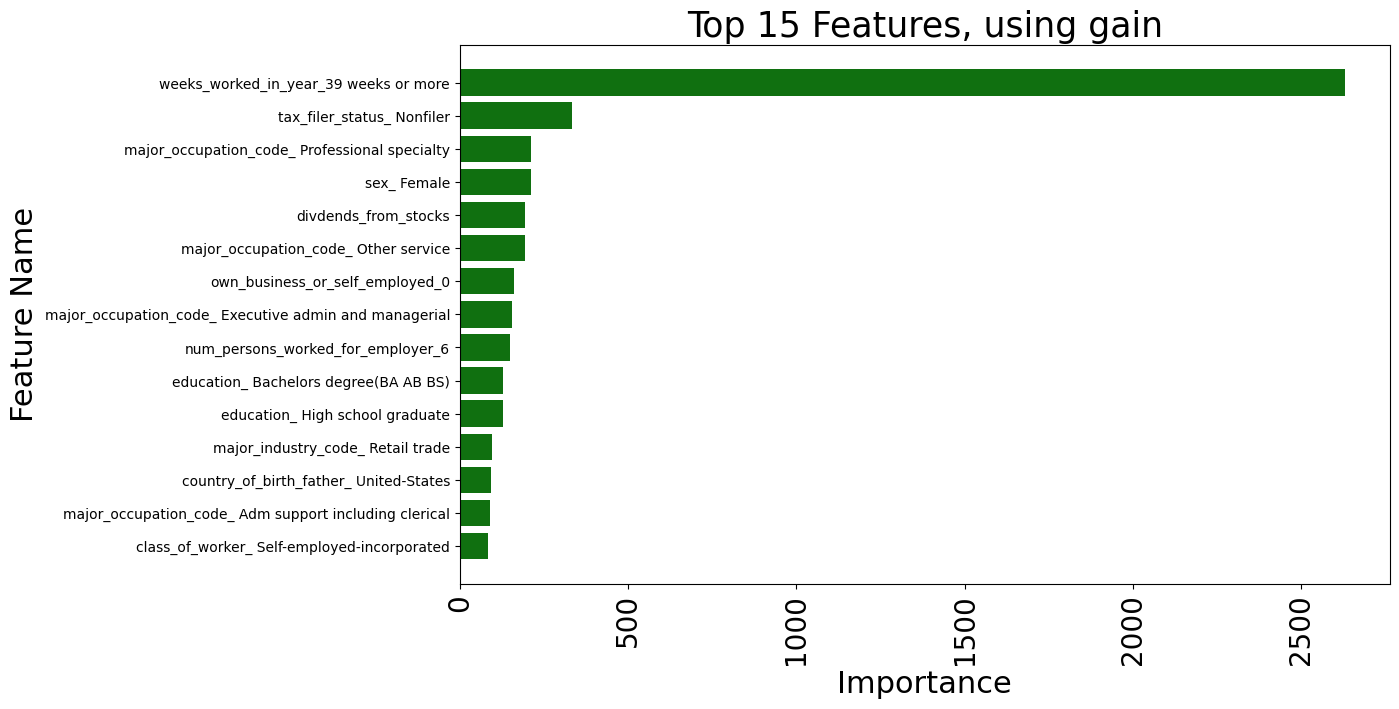

In [34]:
plot_feature_importances(piped_model_gs, X_train, importance_type='gain', n_features_max= 15)

/Users/alexdcruz/ds_projects/dataiku_task/scripts/utils/model_eval.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


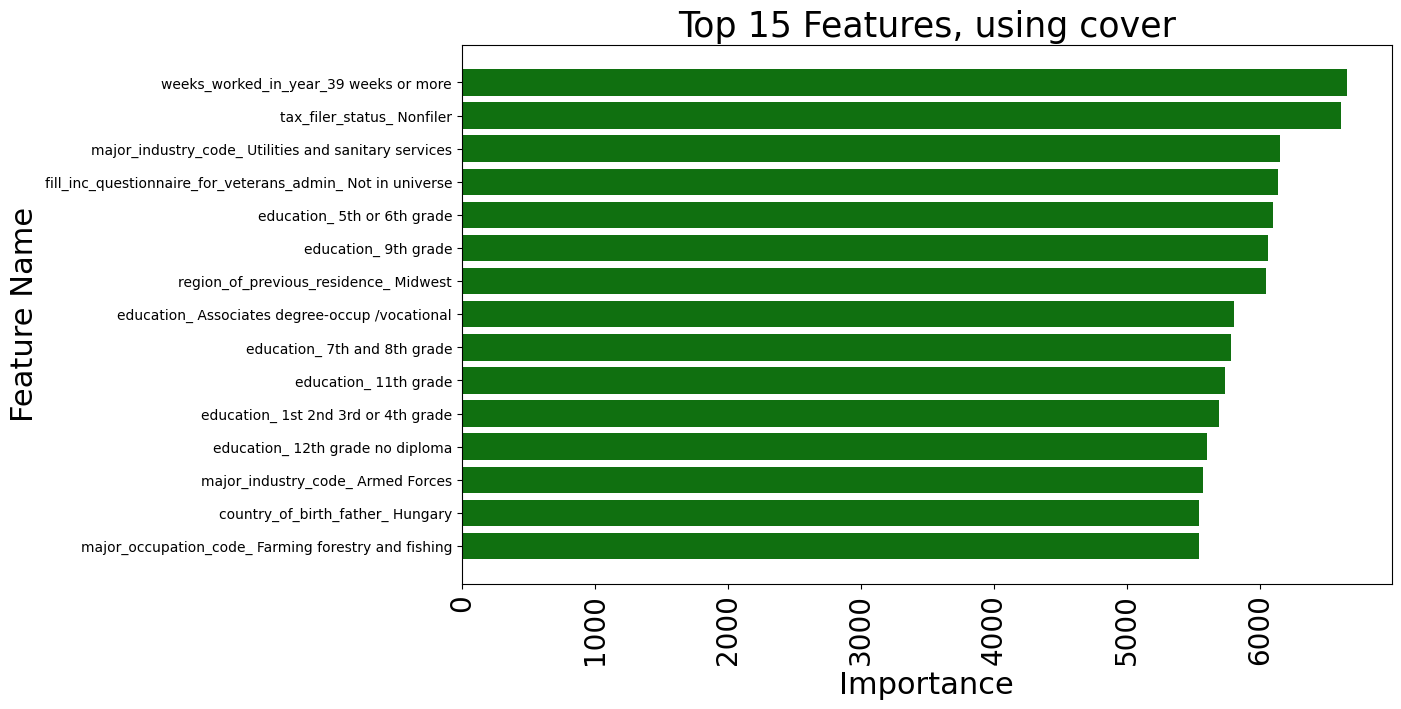

In [35]:
plot_feature_importances(piped_model_gs, X_train, importance_type='cover', n_features_max= 15)

/Users/alexdcruz/ds_projects/dataiku_task/scripts/utils/model_eval.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


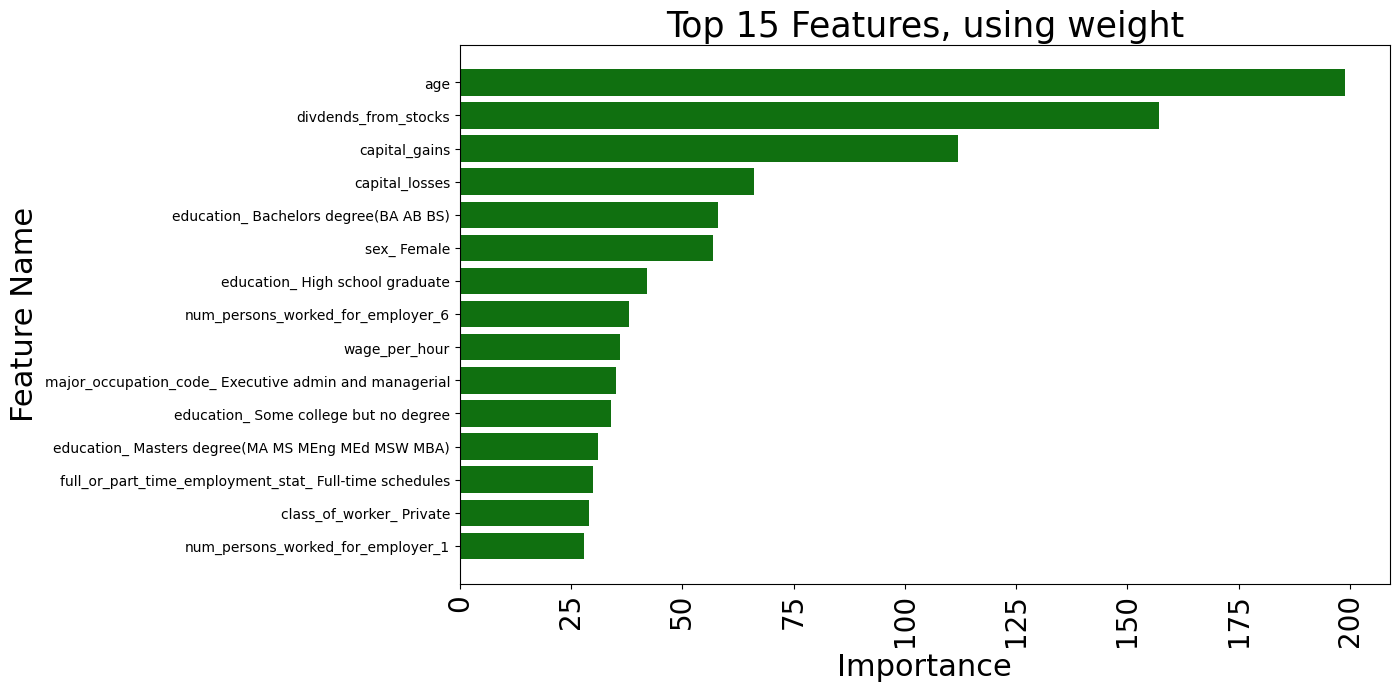

In [36]:
plot_feature_importances(piped_model_gs, X_train, importance_type='weight', n_features_max= 15)

/Users/alexdcruz/ds_projects/dataiku_task/scripts/utils/model_eval.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


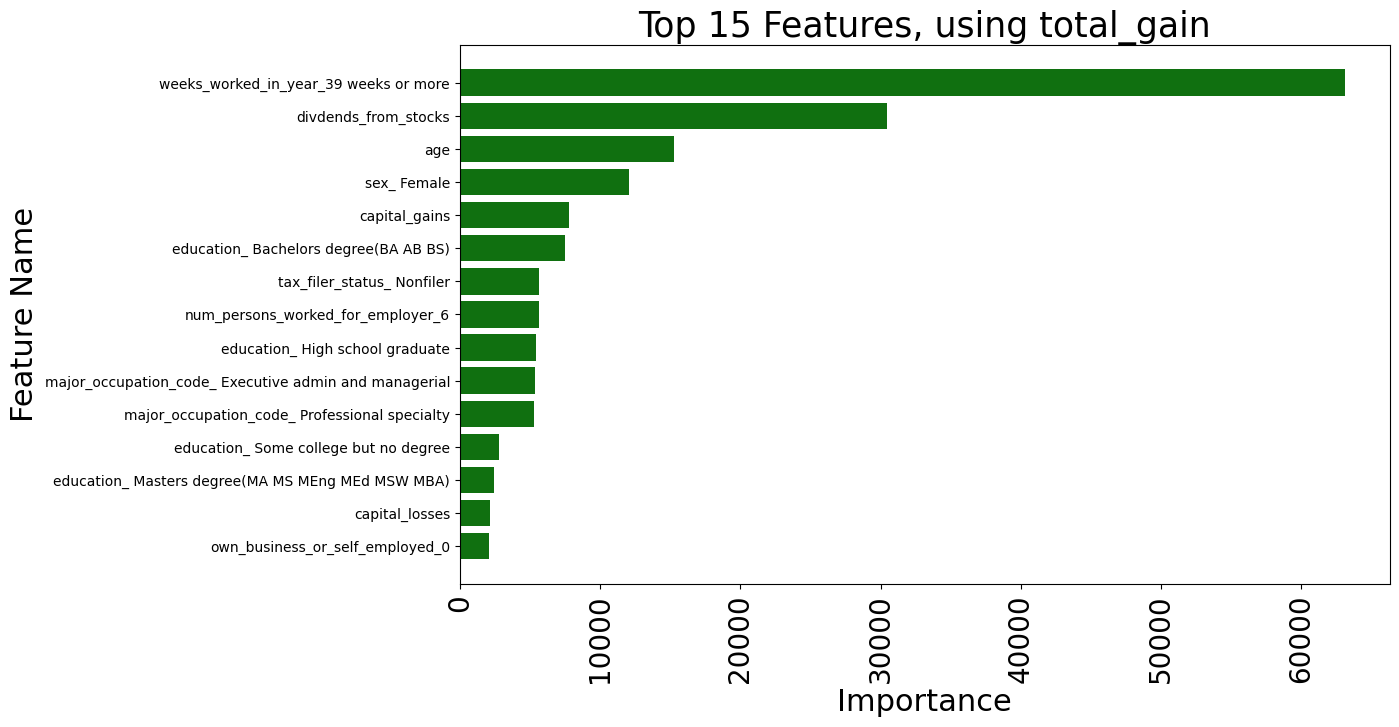

In [37]:
plot_feature_importances(piped_model_gs, X_train, importance_type='total_gain', n_features_max= 15)

/Users/alexdcruz/ds_projects/dataiku_task/scripts/utils/model_eval.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


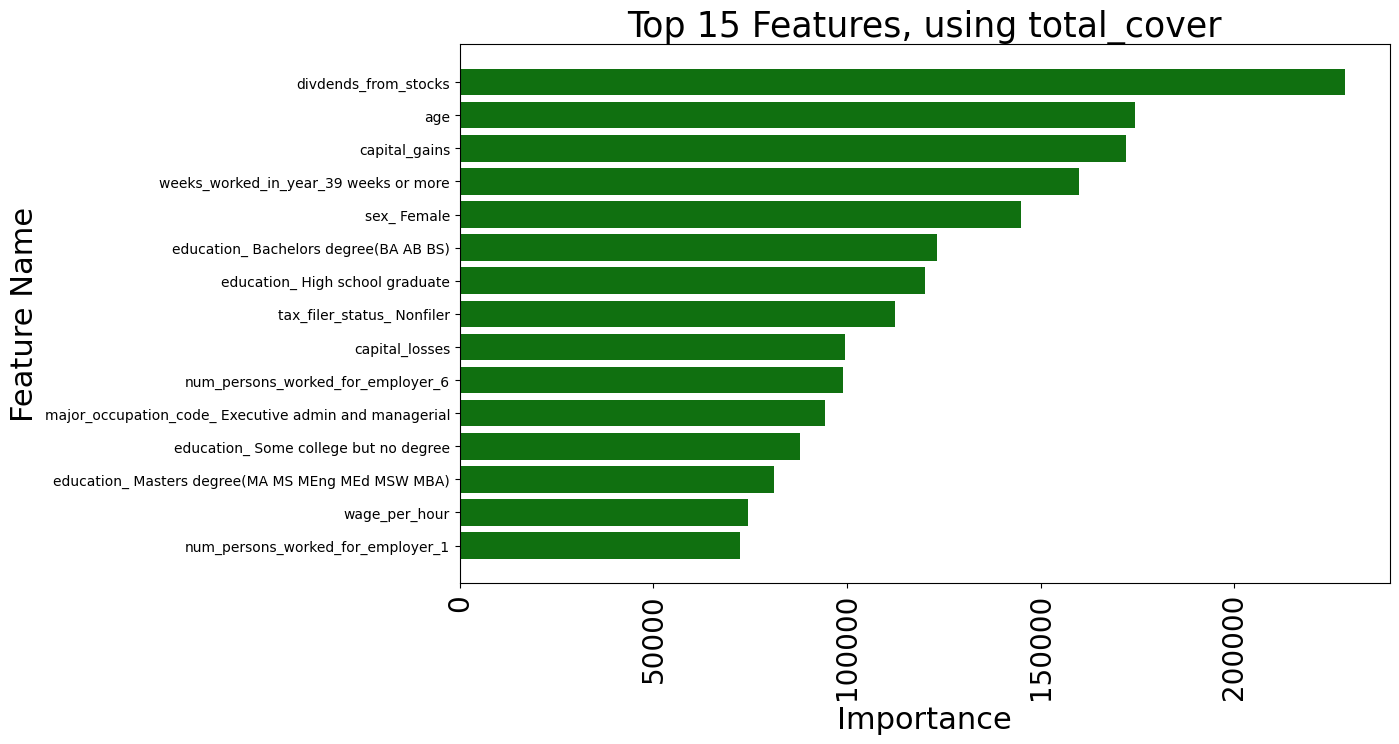

In [38]:
plot_feature_importances(piped_model_gs, X_train, importance_type='total_cover', n_features_max= 15)

We can see that changing the importance type changes the feature importances, not only the values but which features are considered most important. This isn't ideal for trying to decide which characteristics are associated with a person making more or less than 50k.

Let's explore another way to generate feature importances - SHAP values.

In [87]:
# First lets save the model
import joblib
joblib.dump(piped_model_gs, 'models/simple_xgboost.pkl')

['models/simple_xgboost.pkl']

In [40]:
import shap

In [41]:
explainer = shap.TreeExplainer(piped_model_gs.named_steps["xgboostclf"], )

In [42]:
column_names_transformed = piped_model_gs.named_steps['FeatureEngineering'].get_feature_names_out()

In [43]:
X_test_transformed = pd.DataFrame.sparse.from_spmatrix(piped_model_gs.named_steps['FeatureEngineering'].transform(X_test), 
                                                  columns = column_names_transformed)

In [44]:
X_test_transformed.columns = list(map(lambda s: s.replace(' ' , '_').replace(',' , '').replace('<' , ''), X_test_transformed.columns))

In [45]:
# This next step may take a while if run on the whole test set
#shap_values = explainer.shap_values(X_test_subset)
shap_values = explainer(X_test_transformed)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


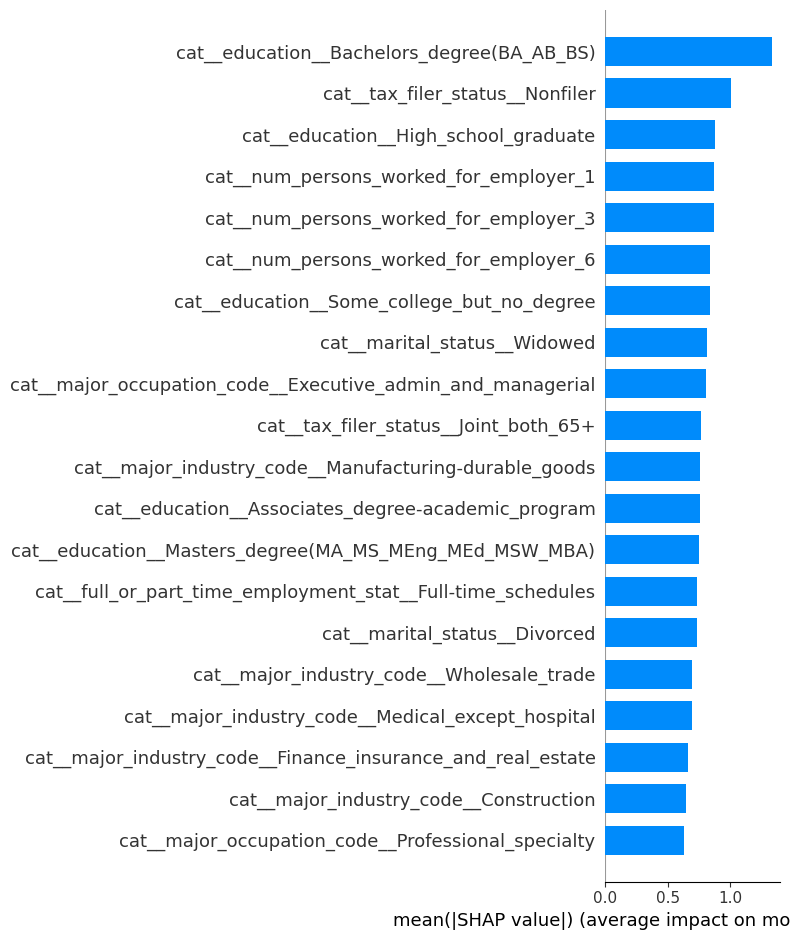

In [47]:
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar", )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


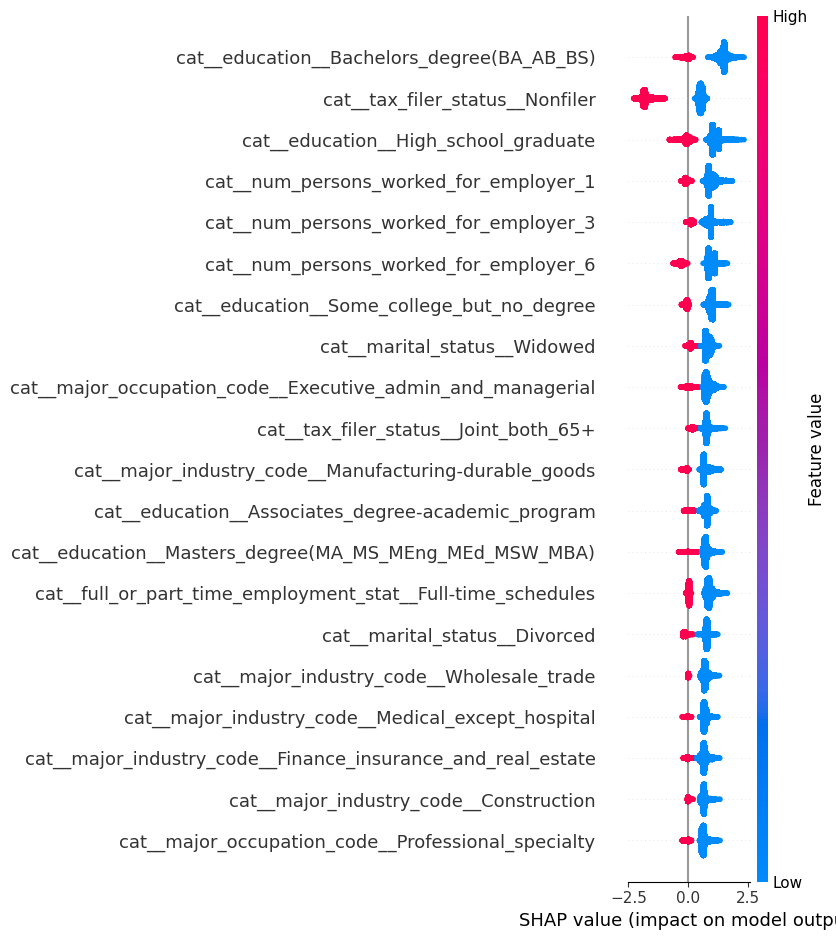

In [48]:
shap.summary_plot(shap_values, X_test_transformed )

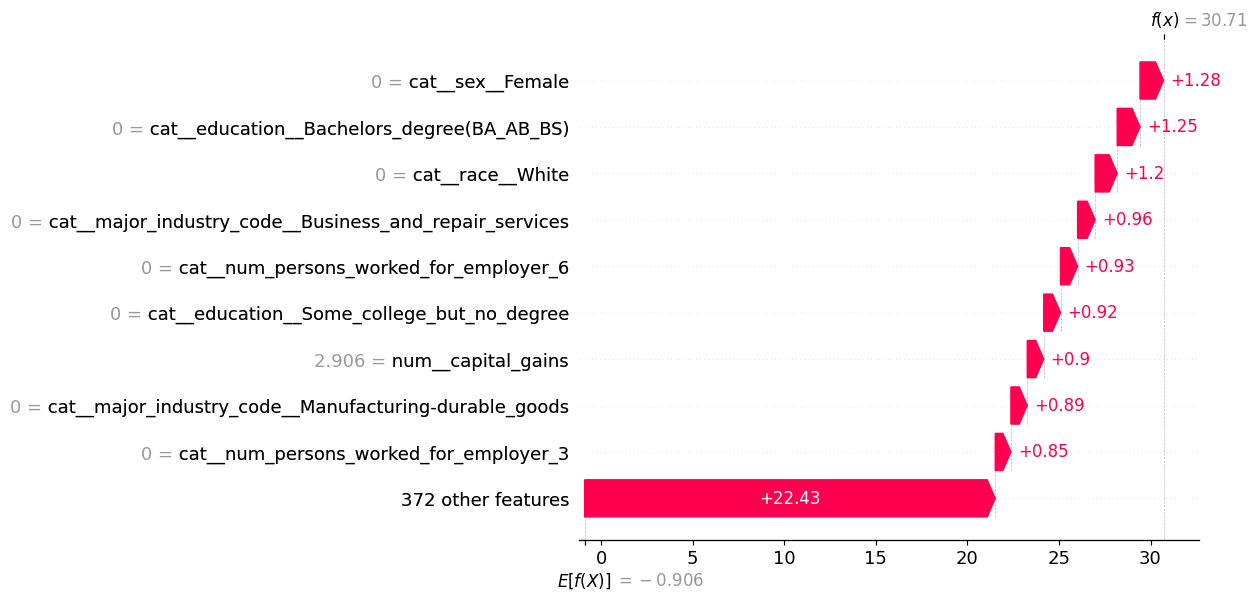

In [50]:
shap.plots.waterfall(shap_values[18])

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test_transformed.iloc[0,:])

Now we're getting somewhere. We have some feature importances but because of splitting out the categorical variables these aren't as useful as they could be.

In [52]:
def get_aggregated_shap_values(no_numerical_features, df, shap_values):
    n_categories = []
    #numerical features aren't one hot encoded
    for i in range(no_numerical_features):
        n_categories.append(1)
    
    #work out how many columns we'll get from one hot encoding
    for feature in df.columns[no_numerical_features:-1]:#may need to be X_test - first workout how long the shap values are and if there is one for each column regardless
        n = df[feature].nunique()
        n_categories.append(n)
    
    #split shap values into lists for each feature
    new_shap_values = []
    for values in shap_values.values:
        values_split = np.split(values, np.cumsum(n_categories))
        
        #sum values within the lists
        values_sum = [sum(l) for l in values_split]
        
        new_shap_values.append(values_sum)
    
    #replace shap values
    shap_values.values = np.array(new_shap_values)
    
    #replace one hot encoded data with categorical data
    og_data = np.array(df)
    shap_values.data = np.array(og_data)
    #update feature names
    shap_values.feature_names = list(df.columns)
    
    return shap_values


In [53]:
shap_values_combined = explainer(X_test_transformed)
combined_shap_values = get_aggregated_shap_values(no_numerical_features= 5, df=X_test, shap_values=shap_values_combined)

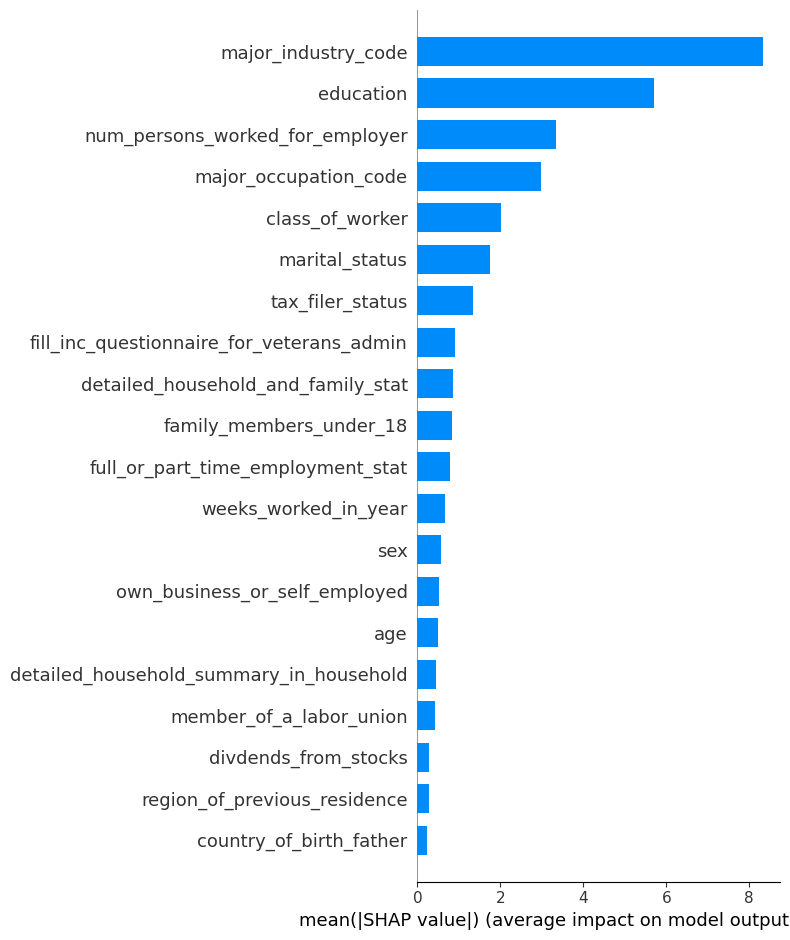

In [54]:
shap.summary_plot(combined_shap_values, X_test, plot_type="bar", )

The features are ordered by how much they influences the model's predictions. On the x axis we have the average of the absolute SHAP value of each feature - for our model major industry code is the most important feature

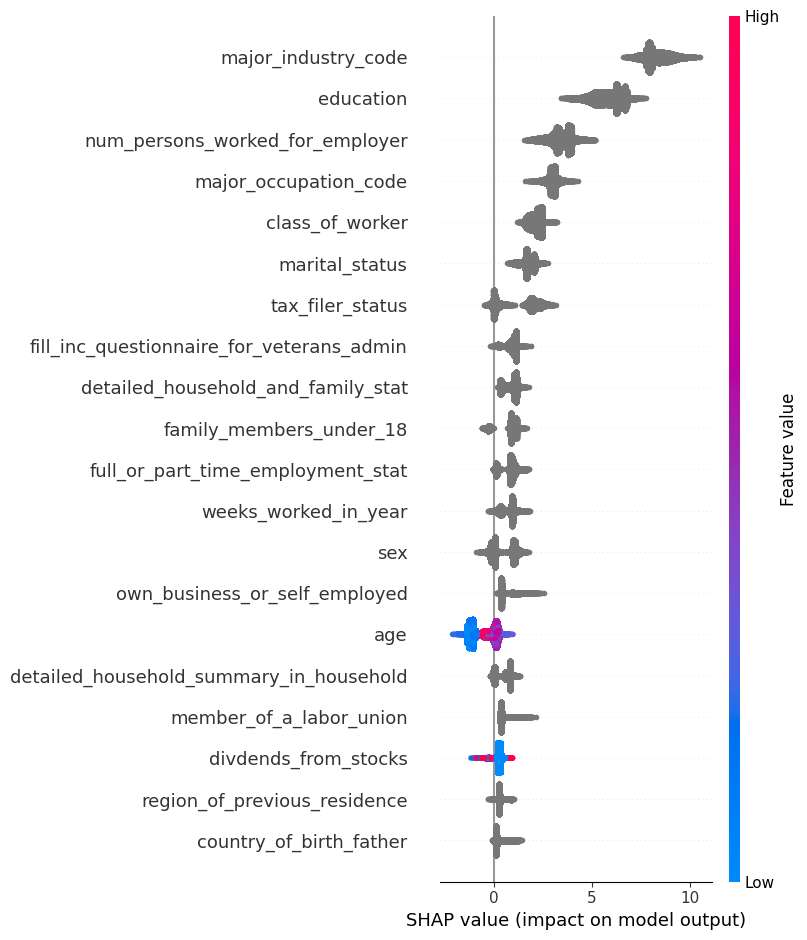

In [55]:
shap.summary_plot(combined_shap_values, X_test)

Let's look at a single row of our test data, first let's use the model to predict the target.

In [56]:
piped_model_gs.predict(X_test.iloc[[0]])

array([0])

In [57]:
y_test[0]

0

We predicted the correct class but what influenced that decision?

Well we can look at the a SHAP waterfall plot for that particular row and we can see which features had the most impact on that decision

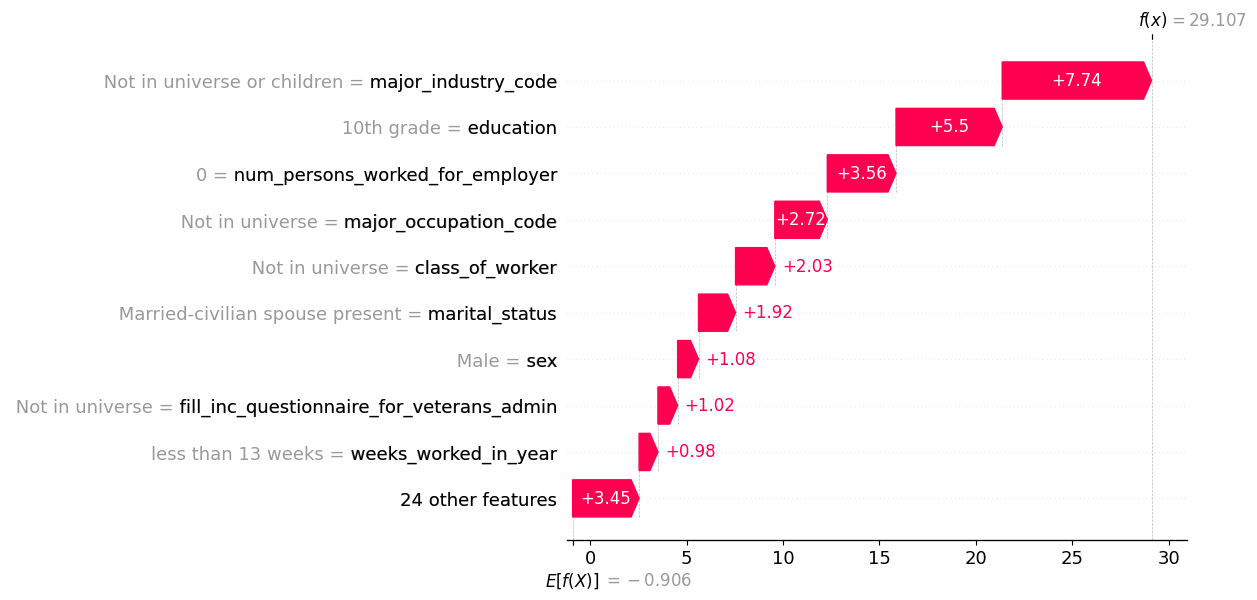

In [91]:
shap.plots.waterfall(combined_shap_values[10])

In [ ]:
y_test_preds = pd.Series(get_scoring_metrics(piped_model_gs, X_test, y_test)['y_validation_preds'])
preds_with_truth = pd.DataFrame(list(zip(y_test_preds, y_test)), columns = ['preds', 'true'])
preds_with_truth[(preds_with_truth['preds'] == 1) & (preds_with_truth['true'] == 1)]

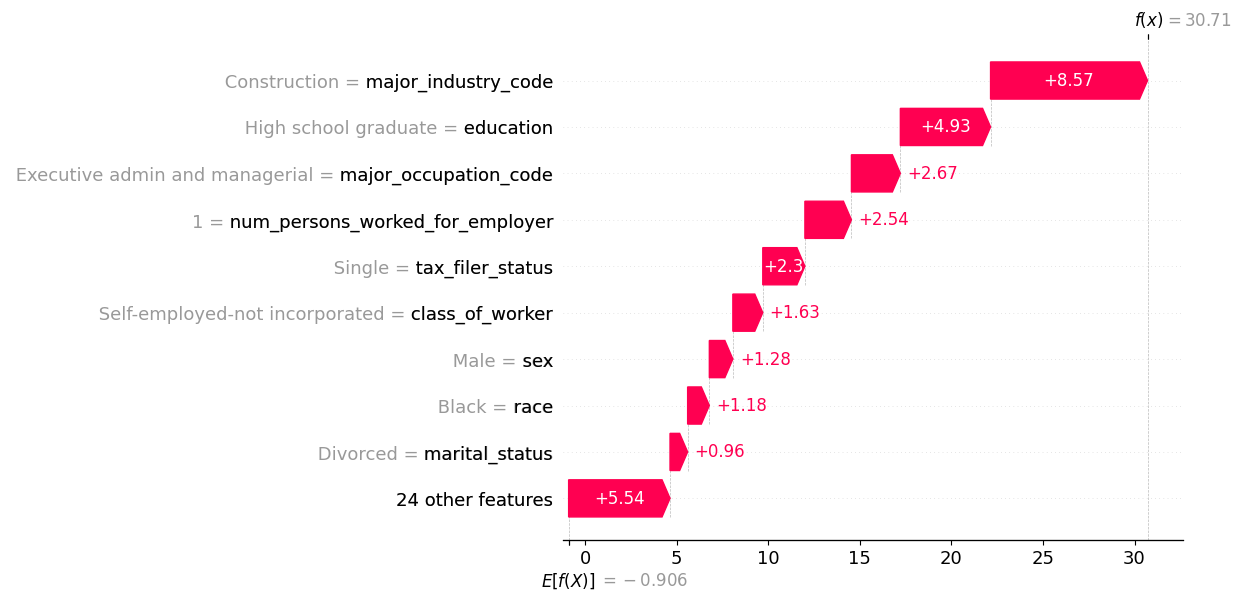

In [59]:
shap.plots.waterfall(combined_shap_values[18])

In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value, combined_shap_values.values[0,:], X_test.iloc[0,:])

In [62]:
shap.initjs()
shap.force_plot(explainer.expected_value, combined_shap_values.values[18,:], X_test.iloc[18,:])